# A Tour of Machine Learning Classifiers Using Scikit-Learn

### Libraries

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### Utilities

In [2]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and color map.
    markers = ('o', 's', '^', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Plot the decision surface.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())


    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Class {cl}',
            edgecolor='black'
        )

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(
            X_test[:, 0], 
            X_test[:, 1],
            c='none', 
            edgecolor='black', 
            alpha=1.0,
            linewidth=1, 
            marker='o',
            s=100, 
            label='Test set'
        )

### Data

In [3]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
np.unique(y)

array([0, 1, 2])

### Data Preprocessing

In [4]:
# Train test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [5]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [6]:
# Scaler. 
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print(f'Misclassified examples: {(y_test != y_pred).sum()}')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Misclassified examples: 1
Accuracy: 0.978


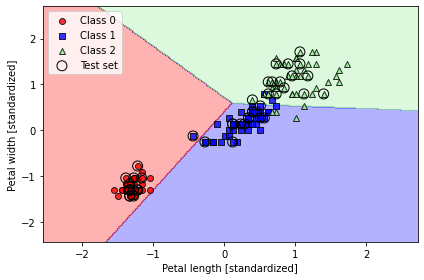

In [8]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Logit

In [9]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

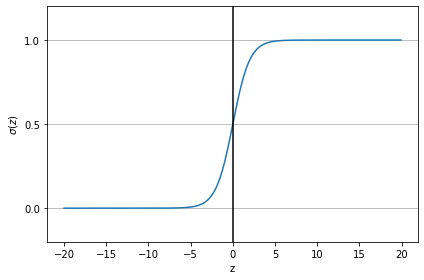

In [10]:
z = np.arange(-20, 20, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.2, 1.2)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

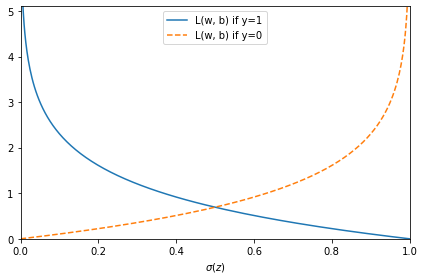

In [13]:
def loss_1(z):
    return -np.log(sigmoid(z))

def loss_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Converting an Adaline implementation into an algorithm for logistic regression

In [19]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int 
        Random number generator seed for random weight intialization.

    Attributes
    ----------
    w_ : 1d-array
        Weights after training.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
        Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta 
        self.n_iter = n_iter
        self.random_state = random_state 

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features
            is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()

            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0])
            self.losses_.append(loss)
        return self 
    
    def net_input(self, X):
        """Calculate net input."""
        return np.dot(X, self.w_) + self.b_ 
    
    def activation(self, z):
        """Compute logistic sigmoid activation."""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Return class label after unit step."""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

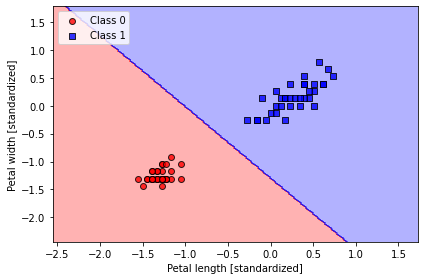

In [20]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset,classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Training a logistic regression model with scikit-learn

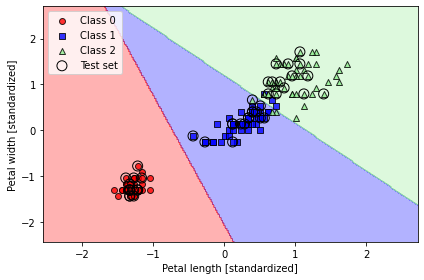

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [25]:
lr.predict_proba(X_test_std[:3, :]).sum(1)

array([1., 1., 1.])

In [26]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

### Tackling overfitting via regularization